**Pré-processamento dataset**



In [4]:
import pandas as pd

# colunas de interesse
selected_columns = ['Q3A', 'Q5A', 'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A', 'Q24A', 'Q26A', 'Q31A', 'Q34A', 'Q37A', 'Q38A', 'Q42A',
                    'gender', 'country', 'education', 'age', 'married']

file_path = 'originalDataset.csv'


df = pd.read_csv(file_path, delimiter='\t')


initial_row_count = len(df)
print(f"Número inicial de linhas no originalDataset: {initial_row_count}")


df.replace('NONE', pd.NA, inplace=True)

# eliminar linhas com nan
df.dropna(inplace=True)

#criterios
criteria = {
    'education': (1, 4),
    'gender': (1, 3),
    'married': (1, 3),
    'age': (18, 100)
}

for column, (low, high) in criteria.items():
    df = df[df[column].between(low, high)]

# contando participantes
country_counts = df['country'].value_counts()

# filtrar países com 30 ou mais participantes
countries_with_min_participants = country_counts[country_counts >= 30].index


df_filtered = df[df['country'].isin(countries_with_min_participants)]


filtered_row_count = len(df_filtered)
print(f"Número de linhas após todos os filtros: {filtered_row_count}")

# Selecionar apenas as colunas desejadas
df_filtered = df_filtered[selected_columns]

# -1 questões da depressoa
item_columns = ['Q3A', 'Q5A', 'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A', 'Q24A', 'Q26A', 'Q31A', 'Q34A', 'Q37A', 'Q38A', 'Q42A']
df_filtered[item_columns] = df_filtered[item_columns] - 1


df_filtered['soma_depressao'] = df_filtered[item_columns].sum(axis=1)

#  mapear o índice de depressão
def mapear_indice_depressao(pontuacao):
    if pontuacao <= 9:
        return 0
    elif pontuacao <= 13:
        return 1
    elif pontuacao <= 20:
        return 2
    elif pontuacao <= 27:
        return 3
    else:
        return 4

# resultado índice
df_filtered['indice_depressao'] = df_filtered['soma_depressao'].apply(mapear_indice_depressao)


country_legend = {number: country for number, country in enumerate(df_filtered['country'].unique(), 1)}
print("Legenda para a coluna 'country':")
for number, country in country_legend.items():
    print(f"{number}: {country}")

# Remover a coluna 'soma_depressao'
df_filtered.drop(columns=['soma_depressao'], inplace=True)

# Salvar o dataset filtrado
df_filtered.to_csv('dataset.csv', index=False)

# Número final de linhas
final_row_count = len(df_filtered)
print(f"Número de linhas finais no dataset filtrado: {final_row_count}")


Número inicial de linhas no originalDataset: 39775
Número de linhas após todos os filtros: 24927
Legenda para a coluna 'country':
1: MY
2: GB
3: DE
4: US
5: AU
6: CA
7: FI
8: ES
9: ID
10: GR
11: IN
12: BR
13: PT
14: RS
15: IT
16: FR
17: RO
18: PL
19: PH
20: IE
21: NZ
22: ZA
23: NL
24: JM
25: MX
26: PK
27: HK
28: SG
29: RU
30: TR
31: EG
32: SA
33: BN
34: JP
Número de linhas finais no dataset filtrado: 24927


**Dados sociodemográficos**

In [11]:
import pandas as pd

data = pd.read_csv('dataset.csv')

# mapear iso
country_name_dict = {
    'AU': 'Australia', 'BN': 'Brunei', 'BR': 'Brazil', 'CA': 'Canada', 'DE': 'Germany', 'EG': 'Egypt',
    'ES': 'Spain', 'FI': 'Finland', 'FR': 'France', 'GB': 'United Kingdom', 'GR': 'Greece', 'HK': 'Hong Kong',
    'ID': 'Indonesia', 'IE': 'Ireland', 'IN': 'India', 'IT': 'Italy', 'JM': 'Jamaica', 'JP': 'Japan',
    'MX': 'Mexico', 'MY': 'Malaysia', 'NL': 'Netherlands', 'NZ': 'New Zealand', 'PH': 'Philippines',
    'PK': 'Pakistan', 'PL': 'Poland', 'PT': 'Portugal', 'RO': 'Romania', 'RS': 'Serbia', 'RU': 'Russia',
    'SA': 'Saudi Arabia', 'SG': 'Singapore', 'TR': 'Turkey', 'US': 'United States', 'ZA': 'South Africa'
}

# mapear os países para seus respectivos continentes
continent_dict = {
    'AU': 'Australia/New Zealand', 'BN': 'Asia', 'BR': 'South America', 'CA': 'North America', 'DE': 'Europe',
'EG': 'Africa', 'ES': 'Europe', 'FI': 'Europe', 'FR': 'Europe', 'GB': 'Europe', 'GR': 'Europe',
    'HK': 'Asia', 'ID': 'Asia', 'IE': 'Europe', 'IN': 'Asia', 'IT': 'Europe', 'JM': 'North America',
        'JP': 'Asia', 'MX': 'North America', 'MY': 'Asia', 'NL': 'Europe', 'NZ': 'Australia/New Zealand',
    'PH': 'Asia', 'PK': 'Asia', 'PL': 'Europe', 'PT': 'Europe', 'RO': 'Europe', 'RS': 'Europe',
    'RU': 'Europe', 'SA': 'Asia', 'SG': 'Asia', 'TR': 'Asia', 'US': 'North America', 'ZA': 'Africa'
}

# testa se as colunas country e indice_depressao estão no dataset
if 'country' in data.columns and 'indice_depressao' in data.columns:

    data['continent'] = data['country'].map(continent_dict)


    print("Exemplo de mapeamento de países para continentes:")
    print(data[['country', 'continent']].head())

    # contagem /continente
    continent_counts = data['continent'].value_counts()

    for continent in continent_counts.index:
        print(f"\nContinente: {continent}, Total de participantes: {continent_counts[continent]}")
        countries_in_continent = data[data['continent'] == continent]['country'].value_counts()

        continent_avg_depression = 0
        country_count = 0

        for country_code, count in countries_in_continent.items():
            avg_depression = data[data['country'] == country_code]['indice_depressao'].mean()
            country_name = country_name_dict[country_code]  # Obter o nome do país
            print(f"  País: {country_name}, Participantes: {count}, Média do Índice de Depressão: {avg_depression:.2f}")

            # somar para calcular a média do continente
            continent_avg_depression += avg_depression
            country_count += 1

        continent_avg_depression /= country_count
        print(f"Média do Índice de Depressão no Continente ({continent}): {continent_avg_depression:.2f}")

    # exibir a soma total de todos os participantes
    total_participants = continent_counts.sum()
    print(f"\nTotal de participantes em todos os continentes: {total_participants}")

else:
    print("As colunas 'country' ou 'indice_depressao' não foram encontradas no dataset.")


Exemplo de mapeamento de países para continentes:
  country      continent
0      MY           Asia
1      GB         Europe
2      DE         Europe
3      US  North America
4      US  North America

Continente: Asia, Total de participantes: 19180
  País: Malaysia, Participantes: 17252, Média do Índice de Depressão: 2.12
  País: Indonesia, Participantes: 642, Média do Índice de Depressão: 2.32
  País: Philippines, Participantes: 472, Média do Índice de Depressão: 2.46
  País: India, Participantes: 331, Média do Índice de Depressão: 2.23
  País: Singapore, Participantes: 123, Média do Índice de Depressão: 2.08
  País: Brunei, Participantes: 97, Média do Índice de Depressão: 2.18
  País: Japan, Participantes: 74, Média do Índice de Depressão: 1.84
  País: Turkey, Participantes: 54, Média do Índice de Depressão: 2.39
  País: Pakistan, Participantes: 53, Média do Índice de Depressão: 2.32
  País: Saudi Arabia, Participantes: 43, Média do Índice de Depressão: 1.91
  País: Hong Kong, Partic

In [15]:
import json


with open("paises.json", "r", encoding="utf-8") as file:
    geojson_data = json.load(file)
# extrair os nomes dos países
country_names_from_geojson = [feature["properties"]["name"] for feature in geojson_data["features"]]
print(country_names_from_geojson)


['Afghanistan', 'Angola', 'Albania', 'United Arab Emirates', 'Argentina', 'Armenia', 'Antarctica', 'French Southern and Antarctic Lands', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'The Bahamas', 'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'Brunei', 'Bhutan', 'Botswana', 'Central African Republic', 'Canada', 'Switzerland', 'Chile', 'China', 'Ivory Coast', 'Cameroon', 'Democratic Republic of the Congo', 'Republic of the Congo', 'Colombia', 'Costa Rica', 'Cuba', 'Northern Cyprus', 'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt', 'Eritrea', 'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'Falkland Islands', 'France', 'Gabon', 'United Kingdom', 'Georgia', 'Ghana', 'Guinea', 'Gambia', 'Guinea Bissau', 'Equatorial Guinea', 'Greece', 'Greenland', 'Guatemala', 'French Guiana', 'Guyana', 'Honduras', 'Croatia', 'Haiti', 'Hunga

**Experimento**

In [5]:
import pandas as pd


df = pd.read_csv('dataset.csv')
# encontra  colunas categorizáveis
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()


print(f"Colunas categorizáveis identificadas para One-Hot Encoding: {categorical_columns}")


categorical_columns = [col for col in categorical_columns if col != 'indice_depressao']

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# adicionar 'indice_depressao' de volta
df_encoded['indice_depressao'] = df['indice_depressao']


df_encoded.to_csv('dataset_one_hot_encoded.csv', index=False)

print(f"Número de linhas no dataset codificado: {len(df_encoded)}")
print(f"Número de colunas no dataset codificado: {len(df_encoded.columns)}")


Colunas categorizáveis identificadas para One-Hot Encoding: ['country']
Número de linhas no dataset codificado: 24927
Número de colunas no dataset codificado: 53


In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


data = pd.read_csv('dataset_one_hot_encoded.csv')

# x e y
X = data.drop(columns=['indice_depressao'])
y = data['indice_depressao']

#  treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalização
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# SMOTE (para balanceamento de classes)
smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)


modelos = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Regressão Logística': LogisticRegression(),
    'K-Vizinhos Mais Próximos': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Árvore de Decisão': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

#  calcular as métricas
def calcular_metricas(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return precision, recall, f1

# Validação cruzada
resultados = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# armazenar as métricas de cada iteração da validação cruzada
resultados_json = {}

# Validação cruzada para todos os modelos
for nome, modelo in modelos.items():
    acc_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    acc_list_modelo = []
    f1_list_modelo = []

    # 10-fold Cross-validation
    for i, (train_index, test_index) in enumerate(skf.split(X_train_scaled, y_train)):
        X_train_fold, X_test_fold = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # treinamento do modelo
        modelo.fit(X_train_fold, y_train_fold)
        y_pred = modelo.predict(X_test_fold)

        # calculando as métricas
        acc = accuracy_score(y_test_fold, y_pred)
        precision, recall, f1 = calcular_metricas(y_test_fold, y_pred)

        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        # Guardar resultados para o teste de Shapiro-Wilk
        acc_list_modelo.append(acc)
        f1_list_modelo.append(f1)

    # Armazenar as métricas médias para cada modelo
    resultados[nome] = {
        'Acurácia': round(np.mean(acc_list), 4),
        'Precisão': round(np.mean(precision_list), 4),
        'Sensibilidade': round(np.mean(recall_list), 4),
        'F1-score': round(np.mean(f1_list), 4),
    }

    resultados_json[nome] = {
        'acuracia': acc_list_modelo,
        'f1_score': f1_list_modelo
    }


with open('resultados_validacao_cruzada.json', 'w') as f:
    json.dump(resultados_json, f)


resultados_df = pd.DataFrame(resultados).T
print(resultados_df)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

                          Acurácia  Precisão  Sensibilidade  F1-score
Random Forest               0.9592    0.9594         0.9592    0.9592
SVM                         0.9966    0.9966         0.9966    0.9966
Regressão Logística         0.9969    0.9969         0.9969    0.9969
K-Vizinhos Mais Próximos    0.9187    0.9231         0.9187    0.9192
Naive Bayes                 0.6854    0.7350         0.6854    0.6866
Árvore de Decisão           0.8463    0.8462         0.8463    0.8461
AdaBoost                    0.4936    0.5946         0.4936    0.4359


In [ ]:
#Conteúdo resultados_validacao_cruzada.json {"Random Forest": {"acuracia": [0.9539720422775315, 0.9614728946471189, 0.9614728946471189, 0.9611319468121378, 0.9607909989771565, 0.9631650750341064, 0.9580491132332879, 0.9577080491132333, 0.9566848567530696, 0.9577080491132333], "f1_score": [0.9539622048762328, 0.9614933571619992, 0.9614545620255276, 0.9612152578593927, 0.9608208693273189, 0.9631659356120029, 0.9580628743910905, 0.9577620328589864, 0.9567205654530644, 0.9576919082388916]}, "SVM": {"acuracia": [0.9962495738152063, 0.9976133651551312, 0.9969314694851688, 0.9942038868053188, 0.9982952608250938, 0.9986357435197817, 0.9962482946793997, 0.9955661664392906, 0.9955661664392906, 0.9965893587994543], "f1_score": [0.9962495029129428, 0.9976144971361536, 0.9969320406462485, 0.9942087133029699, 0.9982964111256593, 0.9986357435197817, 0.9962517234829971, 0.9955659844774608, 0.9955667152464994, 0.9965907873149769]}, "Regress\u00e3o Log\u00edstica": {"acuracia": [0.9965905216501875, 0.9976133651551312, 0.9982952608250938, 0.9965905216501875, 0.99727241732015, 0.9972714870395635, 0.9972714870395635, 0.9959072305593452, 0.9959072305593452, 0.9959072305593452], "f1_score": [0.9965939402599349, 0.997613330927446, 0.9982955482702448, 0.9965916246880505, 0.9972735446010533, 0.9972734892241031, 0.9972714404340801, 0.9959069303554628, 0.9959073817606859, 0.9959091581824401]}, "K-Vizinhos Mais Pr\u00f3ximos": {"acuracia": [0.9185134674394818, 0.9130583020797818, 0.9226048414592567, 0.907944084555063, 0.922945789294238, 0.922237380627558, 0.919849931787176, 0.919849931787176, 0.9195088676671214, 0.9208731241473397], "f1_score": [0.9189366666735015, 0.9134447044856688, 0.9231466045836559, 0.9085710781171259, 0.9232698220303597, 0.9225028659076975, 0.9202987182376953, 0.9203310865893389, 0.91987590600589, 0.9213120843156459]}, "Naive Bayes": {"acuracia": [0.665871121718377, 0.6986021138765769, 0.6713262870780771, 0.6610978520286396, 0.678145243777702, 0.6899727148703957, 0.7193042291950886, 0.7005457025920873, 0.6841746248294679, 0.6845156889495225], "f1_score": [0.6659011268166537, 0.6979812717674522, 0.6720702587999826, 0.6616075480652148, 0.6790408113240752, 0.6910900184984287, 0.7217641304590123, 0.703595219598164, 0.6877898232496588, 0.6854178735906067]}, "\u00c1rvore de Decis\u00e3o": {"acuracia": [0.8462325264234573, 0.8441868394135698, 0.8407773610637572, 0.8475963177633822, 0.8424821002386634, 0.8506139154160982, 0.8465211459754434, 0.8441336971350614, 0.857094133697135, 0.8434515688949522], "f1_score": [0.8462400221472546, 0.8435525408591807, 0.8407991928602685, 0.8481421543198797, 0.8426882770434044, 0.8501679153635475, 0.8461892370263275, 0.8436909337081328, 0.8566894894372016, 0.8431913222737475]}, "AdaBoost": {"acuracia": [0.47494033412887826, 0.4514149335151722, 0.5410842141152403, 0.4821002386634845, 0.5032390044323218, 0.42939972714870395, 0.502387448840382, 0.49590723055934516, 0.5866302864938608, 0.4693042291950887], "f1_score": [0.4136149812641539, 0.3886449672702591, 0.5126244527875667, 0.4118002829641186, 0.43870171771042593, 0.33807277546297826, 0.44472462662149126, 0.42990844014879187, 0.5712085204880255, 0.4093400478832581]}}

**Análises estatísticas**

In [ ]:
pip install scikit-posthocs


In [8]:
import scikit_posthocs as sp
import pandas as pd
import numpy as np
from scipy import stats
import json


with open('resultados_validacao_cruzada.json', 'r') as f:
    resultados = json.load(f)

# meta os modelos com acurácia média > 95%
modelos_selecionados = {nome: dados for nome, dados in resultados.items()
                        if np.mean(dados['acuracia']) > 0.95 and np.mean(dados['f1_score']) > 0.95}

# Shapiro-Wilk para verificar normalidade
normalidade_acuracia = {}
normalidade_f1 = {}

for nome, dados in modelos_selecionados.items():
    #  normalidade para acurácia
    _, p_valor_acuracia = stats.shapiro(dados['acuracia'])
    normalidade_acuracia[nome] = p_valor_acuracia

    #  normalidade para f1_score
    _, p_valor_f1 = stats.shapiro(dados['f1_score'])
    normalidade_f1[nome] = p_valor_f1

# Bartlett (homogeneidade de variâncias)
acuracias = [dados['acuracia'] for dados in modelos_selecionados.values()]
f1_scores = [dados['f1_score'] for dados in modelos_selecionados.values()]

_, p_valor_bartlett_acuracia = stats.bartlett(*acuracias)
_, p_valor_bartlett_f1 = stats.bartlett(*f1_scores)

#  Friedman
resultados_friedman_acuracia = np.array([dados['acuracia'] for dados in modelos_selecionados.values()])
resultados_friedman_f1 = np.array([dados['f1_score'] for dados in modelos_selecionados.values()])

_, p_valor_friedman_acuracia = stats.friedmanchisquare(*resultados_friedman_acuracia)
_, p_valor_friedman_f1 = stats.friedmanchisquare(*resultados_friedman_f1)

#  resultados dos testes
print("Resultados dos Testes de Normalidade (Shapiro-Wilk):")
for nome, p_valor in normalidade_acuracia.items():
    print(f"{nome} (Acurácia): p-valor = {p_valor}")
for nome, p_valor in normalidade_f1.items():
    print(f"{nome} (F1-score): p-valor = {p_valor}")

print("\nResultado do Teste de Bartlett (Acurácia): p-valor =", p_valor_bartlett_acuracia)
print("Resultado do Teste de Bartlett (F1-score): p-valor =", p_valor_bartlett_f1)

print("\nResultado do Teste de Friedman (Acurácia): p-valor =", p_valor_friedman_acuracia)
print("Resultado do Teste de Friedman (F1-score): p-valor =", p_valor_friedman_f1)

# Se o p-valor do teste de Friedman for significativo ocorr e o pós-teste de Nemenyi
if p_valor_friedman_acuracia < 0.05:
    df_acuracia = pd.DataFrame(resultados_friedman_acuracia.T, columns=modelos_selecionados.keys())
    post_hoc_acuracia = sp.posthoc_nemenyi_friedman(df_acuracia)
    print("\nPós-teste de Nemenyi para Acurácia:")
    print(post_hoc_acuracia)

if p_valor_friedman_f1 < 0.05:
    df_f1 = pd.DataFrame(resultados_friedman_f1.T, columns=modelos_selecionados.keys())
    post_hoc_f1 = sp.posthoc_nemenyi_friedman(df_f1)
    print("\nPós-teste de Nemenyi para F1-score:")
    print(post_hoc_f1)


Resultados dos Testes de Normalidade (Shapiro-Wilk):
Random Forest (Acurácia): p-valor = 0.4894289239670076
SVM (Acurácia): p-valor = 0.903785804782599
Regressão Logística (Acurácia): p-valor = 0.26671653949413054
Random Forest (F1-score): p-valor = 0.47209375094739536
SVM (F1-score): p-valor = 0.9040458262289668
Regressão Logística (F1-score): p-valor = 0.26965638613269716

Resultado do Teste de Bartlett (Acurácia): p-valor = 0.0017566372137746023
Resultado do Teste de Bartlett (F1-score): p-valor = 0.00172092148740393

Resultado do Teste de Friedman (Acurácia): p-valor = 0.00036228588397514325
Resultado do Teste de Friedman (F1-score): p-valor = 0.0005004514334406062

Pós-teste de Nemenyi para Acurácia:
                     Random Forest       SVM  Regressão Logística
Random Forest             1.000000  0.007165             0.000658
SVM                       0.007165  1.000000             0.780467
Regressão Logística       0.000658  0.780467             1.000000

Pós-teste de Nemenyi

**Versão das análises estatísticas com autorank**










In [9]:
pip install autorank

  Preparing metadata (setup.py) ... done
  Created wheel for baycomp: filename=baycomp-1.0.3-py3-none-any.whl size=18030 sha256=002771e80709c80410f3666401b8e14f6d814a3845afb551a852ed14b43040e5
  Stored in directory: /root/.cache/pip/wheels/2b/a2/b8/9c0b9ffde746a4e0c20639b46eae34dda4e0588efebde8916e
Successfully built baycomp



Analisando acuracia:

Fail to reject null hypothesis that data is normal for column Random Forest (p=0.489429>=0.016667)
Fail to reject null hypothesis that data is normal for column SVM (p=0.903786>=0.016667)
Fail to reject null hypothesis that data is normal for column Regressão Logística (p=0.266717>=0.016667)
Using Bartlett's test for homoscedacity of normally distributed data
Rejecting null hypothesis that all variances are equal (p=0.001757<0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000362)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
The statistical analysis was conducted for 3 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.267). There

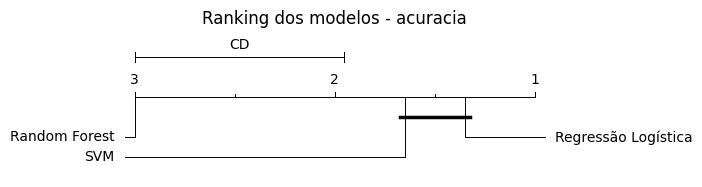


Analisando f1_score:

Fail to reject null hypothesis that data is normal for column Random Forest (p=0.472094>=0.016667)
Fail to reject null hypothesis that data is normal for column SVM (p=0.904046>=0.016667)
Fail to reject null hypothesis that data is normal for column Regressão Logística (p=0.269656>=0.016667)
Using Bartlett's test for homoscedacity of normally distributed data
Rejecting null hypothesis that all variances are equal (p=0.001721<0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000500)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
The statistical analysis was conducted for 3 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.270). There

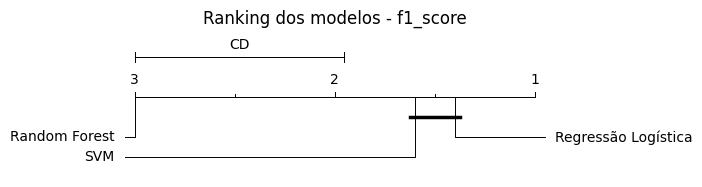

In [10]:
import json
import pandas as pd
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt


with open('resultados_validacao_cruzada.json', 'r') as file:
    data = json.load(file)

# definir métricas e modelos selecionados
metrics = ['acuracia', 'f1_score']
selected_models = {}

#  média superior a 95%
for model, values in data.items():
    mean_accuracy = sum(values['acuracia']) / len(values['acuracia'])
    if mean_accuracy > 0.95:
        selected_models[model] = values

# há modelos selecionados?
if not selected_models:
    print("Nenhum modelo selecionado com acurácia superior a 95%.")
else:
    #  dataFrames para análise estatística
    results = {metric: pd.DataFrame({model: selected_models[model][metric] for model in selected_models}) for metric in metrics}

    # com Autorank para cada métrica
    autorank_results = {}

    for metric, df in results.items():
        print(f"\nAnalisando {metric}:\n")
        rank_result = autorank(df, alpha=0.05, verbose=True)  # significância ajustada para 0,05
        create_report(rank_result)
        plot_stats(rank_result)
        plt.title(f"Ranking dos modelos - {metric}")
        plt.show()
        autorank_results[metric] = rank_result


**Streamlit**

In [19]:
! pip install streamlit

In [21]:
! wget -q -O - ipv4.icanhazip.com

35.221.209.27


In [22]:
!npm install -g localtunnel@2.0.2

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
changed 22 packages in 3s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸

In [24]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.221.209.27:8501

⠴⠦⠧your url is: https://violet-moons-pull.loca.lt
  Stopping...
^C
